In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !ROOT_PATH="/content/drive/MyDrive/PE/detr-tensorflow-main"

# Run From this cell in Local Notebook

In [3]:
ROOT_PATH="/home/falcon2212/college/sem8/PE/detr-tensorflow"

In [4]:
!python --version

Python 3.7.10


In [5]:
# !pip install -r $ROOT_PATH/requirements_new.txt

# DETR : Finetuning tutorial

In this tutorial we're gonna explore how to finetune DETR on the Hard hat Workers dataset: https://public.roboflow.com/object-detection/hard-hat-workers.  


## 1. Download the Hard Hat Workers Dataset

### Download and unzip files

**Copy paste your download link bellow** to download the dataset into your home/data folder (feel free to set the path you want)

In [6]:
# !mkdir $ROOT_PATH/data

In [7]:
# !mkdir $ROOT_PATH/data
# !mkdir $ROOT_PATH/data/hardhat/
# !wget -O $ROOT_PATH/data/hardhat/hard-hat-workers-dataset.zip https://public.roboflow.com/ds/orIMk2wdVU?key=ZCZZ9eRUvz

# !unzip $ROOT_PATH/data/hardhat/hard-hat-workers-dataset.zip -d $ROOT_PATH/data/hardhat/
# !ls $ROOT_PATH/data/hardhat/

In [8]:
# !mkdir $ROOT_PATH/data
# !mkdir $ROOT_PATH/data/maskwearing1
# !wget -O $ROOT_PATH/data/maskwearing1/mask-wearing-dataset.zip https://public.roboflow.com/ds/pqbqlhfrrr?key=58MYthuV2e
# !unzip $ROOT_PATH/data/maskwearing1/mask-wearing-dataset.zip -d $ROOT_PATH/data/maskwearing1/
# !ls $ROOT_PATH/data/maskwearing1/

## 2. Add detr_tf to your PYTHONPATH

In [9]:
import sys
# Set the path to the repository here
sys.path.append(ROOT_PATH)
import detr_tf

### If you're GPU is use for graphical display, you might need the following

In [10]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) == 1:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## 3. Create your training config

In [11]:
DATASET_PATH="/data/maskwearing/"

In [12]:
import sys
# Set the path to detr_tf
# sys.path.append("../")

from detr_tf.data import load_tfcsv_dataset
from detr_tf.training_config import TrainingConfig, DataConfig

class MyConfig(TrainingConfig):
    def __init__(self):
        super().__init__()
#         self.data_dir = ROOT_PATH+DATASET_PATH
        self.datadir = ROOT_PATH+DATASET_PATH
        self.data = DataConfig(data_dir="", img_dir="test", ann_file="test/_annotations.csv")
        self.batch_size = 1

config = MyConfig()
iterator, class_names = load_tfcsv_dataset(config, config.batch_size, augmentation=False)
print(iterator.cardinality())

tf.Tensor(-2, shape=(), dtype=int64)


In [13]:
!pip --version

pip 21.1.1 from /home/falcon2212/college/sem8/PE/detr-tensorflow/environments/facemaskdetector_env/lib/python3.7/site-packages/pip (python 3.7)


### Load the Hard Hat Workers Dataset
Please, checkout the **How to load a dataset** notebook on the repository for more information

In [14]:
# !pip uninstall imgaug && pip uninstall albumentations && pip install git+https://github.com/aleju/imgaug.git


In [15]:
from detr_tf.data import load_tfcsv_dataset

# Load the dataset and exclude the person class (for some reason not all person are labeled on the training set)
print(config.data.ann_dir)
print(config.data.ann_file)
print(config.img_dir)
# train_iterator, class_names = load_tfcsv_dataset("train", "train", "train", batch_size=config.batch_size, config=config, augmentation=True, exclude=["person"])
train_iterator, class_names = load_tfcsv_dataset(config = config, batch_size=config.batch_size, augmentation=True, img_dir="train", ann_file="train/_annotations.csv")
valid_iterator, class_names = load_tfcsv_dataset(config = config, batch_size=config.batch_size, augmentation=False, img_dir="test", ann_file="test/_annotations.csv")
print(train_iterator.cardinality())
print(valid_iterator.cardinality())
print("class_names", class_names)

None
test/_annotations.csv
None
tf.Tensor(-2, shape=(), dtype=int64)
tf.Tensor(-2, shape=(), dtype=int64)
class_names ['background', 'mask', 'no-mask']


### Load the DETR model

In [16]:
from detr_tf.networks.detr import get_detr_model
# Load the pretrained DETR model with new heads at the top
# include_top: We do not include the last layers that predicts the bbox pos and class (include_top=False)
# nb_class: We add new layers on top of the model to predicts the bbox pos and class with three class (nb_class=3), background, helmet, face
# weights: Use the "detr" weight to init the model
detr = get_detr_model(config, include_top=False, nb_class=3, weights="detr")
detr.summary()

Load weights from weights/detr/detr.ckpt
Model: "detr_finetuning"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
detr (Functional)               (6, None, 100, 256)  41449152    input_2[0][0]                    
__________________________________________________________________________________________________
pos_layer (Sequential)          (6, None, 100, 4)    132612      detr[0][0]                       
__________________________________________________________________________________________________
cls_layer (Dense)               (6, None, 100, 3)    771         detr[0][0]                       
___________________________________________

#### First, change the config to train  only the layers on top of the transformers

In [17]:
# Train/finetune the transformers only
config.train_backbone = tf.Variable(False)
config.train_transformers = tf.Variable(False)
config.train_nlayers = tf.Variable(True)

#### Set the last layers learning rate

In [18]:
config.nlayers_lr = tf.Variable(1e-3)

In [19]:
from detr_tf.optimizers import setup_optimizers
# Setup the optimziers and the trainable variables
optimzers = setup_optimizers(detr, config)

### Train the last layers on top of the transformer for one epoch

- **ce** is the cross entropy loss of the layer that predicts the bbox class
- **giou** and **l1** loss are the positional loss  of the layer that predicts the bbox pos (center_x, center_y, width, height)


In [20]:
# from detr_tf.inference import numpy_bbox_to_image
# import numpy as np
# import matplotlib.pyplot as plt
# count = 0
# for element in list_iterator:
#     images, target_bbox, target_class = element
#     print("images.shape", images.shape)
#     print("target_bbox.shape", target_bbox.shape)
#     print("target_class.shape", target_class.shape)
#     print(count)
#     count+=1
#     # Plot image
#     image = numpy_bbox_to_image(
#         np.array(images[0]),
#         np.array(target_bbox[0]),
#         labels=np.array(target_class[0]),
#         scores=None,
#         class_name=class_names,
#         config=config
#     )
#     plt.imshow(image)
#     # break

In [22]:
from detr_tf import training
training.fit(detr, valid_iterator, optimzers, config, epoch_nb=0, class_names=class_names)

Epoch: [0], 	 Step: [0], 	 ce: [0.69] 	 giou : [1.15] 	 l1 : [1.17] 	 time : [0.00]


### Let's check the training results after one epoch

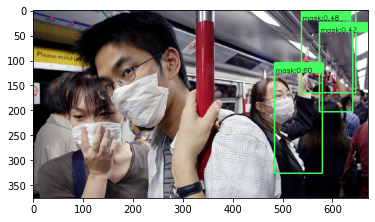

In [29]:
from detr_tf.inference import get_model_inference, numpy_bbox_to_image
import matplotlib.pyplot as plt
import numpy as np


for valid_images, target_bbox, target_class in train_iterator:
    
    m_outputs = detr(valid_images, training=False)
    predicted_bbox, predicted_labels, predicted_scores = get_model_inference(m_outputs, config.background_class, bbox_format="xy_center")

    result = numpy_bbox_to_image(
        np.array(valid_images[0]),
        np.array(predicted_bbox),
        np.array(predicted_labels),
        scores=np.array(predicted_scores),
        class_name=class_names, 
        config=config
    )
    plt.imshow(result)
    plt.show()
    break

## Now to get better results we can train the new layers along with the transformers and let the backbone freeze

In [30]:
# After the first epoch, we finetune the transformers and the new layers
config.train_transformers.assign(True)
config.transformers_lr.assign(1e-4)
config.nlayers_lr.assign(1e-3)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.001>

In [31]:
for epoch in range(1, 6):
    training.fit(detr, train_iterator, optimzers, config, epoch_nb=epoch, class_names=class_names)

Epoch: [1], 	 Step: [0], 	 ce: [0.78] 	 giou : [0.69] 	 l1 : [0.38] 	 time : [0.00]


KeyboardInterrupt: 

In [ ]:
from detr_tf.inference import get_model_inference, numpy_bbox_to_image
import matplotlib.pyplot as plt
import numpy as np



for valid_images, target_bbox, target_class in valid_iterator:
    
    m_outputs = detr(valid_images, training=False)
    predicted_bbox, predicted_labels, predicted_scores = get_model_inference(m_outputs, config.background_class, bbox_format="xy_center")

    result = numpy_bbox_to_image(
        np.array(valid_images[0]),
        np.array(predicted_bbox),
        np.array(predicted_labels),
        scores=np.array(predicted_scores),
        class_name=class_names, 
        config=config
    )
    plt.imshow(result)
    plt.show()
    # break